# Определение перспективного тарифа для телекоммуникационной компании

## Задача

Сравнить тарифы «Смарт» и «Ультра» и компании «Мегалайн» с целью корректировки рекламного бюджета, имея данные о 500 пользователях компании.

## Описание тарифов

### Тариф «Смарт»

1. Ежемесячная плата: 550 рублей
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
    * минута разговора: 3 рубля
    * сообщение: 3 рубля
    * 1 Гб интернет-трафика: 200 рублей
    
### Тариф «Ультра»
1. Ежемесячная плата: 1950 рублей
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
    * минута разговора: 1 рубль
    * сообщение: 1 рубль
    * 1 Гб интернет-трафика: 150 рублей
    
**Внимание**: «Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.

## Описание данных

Таблица **calls** (информация о звонках):
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

Таблица **messages** (информация о сообщениях):
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

Таблица **internet** (информация об интернет-сессиях):
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

Таблица **tariffs** (информация о тарифах):
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

Таблица **users** (информация о пользователях):
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана

## Оглавление

### [Шаг 1. Открытие файлов с данными и изучение общей информации](#read_data)
### [Шаг 2. Подготовка данных](#data_preparation)
- [Дополнительные подсчёты для каждого пользователя](#additional_calculations)

### [Шаг 3. Анализ данных](#data_analysis)
### [Шаг 4. Проверка гипотез](#hypothesis_testing)
- [Какой тариф лучше?](#best_tariff)

### [Шаг 5. Общий вывод](#general_conclusion)

## Ход работы

#### Импортируем необходимые для работы библиотеки.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats as st

## <a id='read_data'>Шаг 1. Открытие файлов с данными и изучение общей информации</a>

#### Откроем файлы с данными и сохраним их в соответствующих переменных.

In [2]:
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

#### Изучим общую информацию.

In [3]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [4]:
calls.head(10)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


In [5]:
calls.describe().round(2)

,duration,user_id
count,202607.00,202607.00
mean,6.76,1253.94
std,5.84,144.72
min,0.00,1000.00
25%,1.30,1126.00
50%,6.00,1260.00
75%,10.70,1379.00
max,38.00,1499.00


In [6]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [7]:
internet.head(10)

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
5,5,1000_5,399.97,2018-10-02,1000
6,6,1000_6,540.08,2018-09-07,1000
7,7,1000_7,415.70,2018-07-11,1000
8,8,1000_8,505.40,2018-10-08,1000
9,9,1000_9,345.54,2018-09-03,1000


In [8]:
internet.describe().round(2)

,Unnamed: 0,mb_used,user_id
count,149396.00,149396.00,149396.00
mean,74697.50,370.19,1252.10
std,43127.05,278.30,144.05
min,0.00,0.00,1000.00
25%,37348.75,138.19,1130.00
50%,74697.50,348.02,1251.00
75%,112046.25,559.55,1380.00
max,149395.00,1724.83,1499.00


In [9]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [10]:
messages.head(10)

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


In [11]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [12]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [13]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [14]:
users['churn_date'].isna().sum()

462

In [15]:
users['churn_date'].isna().mean()

0.924

In [16]:
users.duplicated().sum()

0

In [17]:
users.head(10)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


In [18]:
users.describe().round(2)

,user_id,age
count,500.00,500.00
mean,1249.50,46.59
std,144.48,16.67
min,1000.00,18.00
25%,1124.75,32.00
50%,1249.50,46.00
75%,1374.25,62.00
max,1499.00,75.00


In [19]:
users['tariff'].unique()

array(['ultra', 'smart'], dtype=object)

### Вывод

Имеем 5 датафреймов:

1. Датафрейм **calls** состоит из 202607 строк и 4 столбцов. Пропусков нет. Тип данных в столбце *call_date* — *object*, а не *datetime*. Значения в столбце *duration* представлены числами с плавающей запятой, хотя «Мегалайн» всегда округляет вверх значения минут. Имеются звонки длительностью 0 минут 0 секунд.
2. Датафрейм **internet** состоит из 149396 строк и 5 столбцов. Столбец *Unnamed: 0* является фиктивным и совпадает с индексами строк. Пропусков нет. Тип данных в столбце *session_date* — *object*, а не *datetime*. Значения в столбце *mb_used* представлены числами с плавающей запятой, хотя «Мегалайн» всегда округляет вверх значения мегабайтов.
3. Датафрейм **messages** состоит из 123036 строк и 3 столбцов. Пропусков нет. Тип данных в столбце *message_date* — *object*, а не *datetime*.
4. Датафрейм **tariffs** состоит из 2 строк и 8 столбцов. Пропусков нет.
5. Датафрейм **users** состоит из 500 строк и 8 столбцов. 462 из 500 значений в столбце *churn_date* пропущены. Типы данных в столбцах *churn_date* и *reg_date* — *object*, а не *datetime*.

## <a id='data_preparation'>Шаг 2. Подготовка данных</a>

#### Приведём все даты к формату *datetime*.

In [20]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

#### Округлим минуты и мегабайты вверх и приведём типы данных в соответсвующих столбцах к целочисленному типу.

In [21]:
calls['duration'] = calls['duration'].apply(np.ceil).astype('int')
internet['mb_used'] = internet['mb_used'].apply(np.ceil).astype('int')

#### Посмотрим, какую долю данных о продолжительности звонков составляют звонки длительностью 0 минут.

In [22]:
round((calls.query('duration == 0').shape[0] / calls.shape[0]), 3)

0.196

Оказалось, что практически каждый пятый звонок имеет такую продолжительность. Возможно, это пропущенные звонки самим абонентом или звонки, поступившие собеседнику абонента, пропустившему звонок. В таком случае не обрабатывать их вполне логично. Если звонок продолжительностью менее минуты состоялся, то соответствующее значение округлено до 1 минуты. Если же звонок не состоялся, то абонент не потратил минуту по тарифу или сверх тарифа.

#### Избавимся от фиктивного столбца *Unnamed: 0*.

In [23]:
internet.drop('Unnamed: 0', axis=1, inplace=True)

### <a id='additional_calculations'>Дополнительные подсчёты для каждого пользователя</a>

In [24]:
months = {1: 'январь', 2: 'февраль', 3: 'март', 4: 'апрель', 5: 'май', 6: 'июнь',\
          7: 'июль', 8: 'август', 9: 'сентябрь', 10: 'октябрь', 11: 'ноябрь', 12: 'декабрь'}

#### 1. Количество сделанных звонков и израсходованных минут разговора по месяцам.

In [25]:
calls['month'] = calls['call_date'].dt.month.map(months)
calls_info = calls.pivot_table(index=['user_id', 'month'], \
                               values='duration', \
                               aggfunc=['count', 'sum'])
calls_info.columns = ['calls_total', 'duration_total']
display(calls_info)

calls_total  duration_total
user_id month                                
1000    август             52             408
        декабрь            46             333
        июль               47             340
        июнь               43             172
        май                22             159
...                       ...             ...
1498    сентябрь           59             471
1499    декабрь            69             492
        ноябрь             74             612
        октябрь            68             449
        сентябрь            9              70

[3174 rows x 2 columns]

#### 2. Количество отправленных сообщений по месяцам.

In [26]:
messages['month'] = messages['message_date'].dt.month.map(months)
messages_info = messages.pivot_table(index=['user_id', 'month'], \
                                     values='id', \
                                     aggfunc='count')
messages_info.columns = ['messages_total']
display(messages_info)

messages_total
user_id month                   
1000    август                81
        декабрь               70
        июль                  75
        июнь                  60
        май                   22
...                          ...
1498    сентябрь              44
1499    декабрь               66
        ноябрь                59
        октябрь               48
        сентябрь              11

[2717 rows x 1 columns]

#### 3. Объём израсходованного интернет-трафика по месяцам.

In [27]:
internet['month'] = internet['session_date'].dt.month.map(months)
internet_info = internet.pivot_table(index=['user_id', 'month'], \
                                     values='mb_used', \
                                     aggfunc='sum')
internet_info.columns = ['mb_used_total']
display(internet_info)

mb_used_total
user_id month                  
1000    август            14070
        декабрь            9827
        июль              14016
        июнь              23257
        май                2256
...                         ...
1498    сентябрь          22166
1499    декабрь           13077
        ноябрь            17984
        октябрь           17809
        сентябрь           1848

[3203 rows x 1 columns]

#### 4. Помесячная выручка с каждого пользователя.

In [28]:
entire_info = calls_info.merge(internet_info, on=['user_id', 'month'], \
                               how='outer').reset_index()

In [29]:
entire_info = entire_info.merge(messages_info, on=['user_id', 'month'], \
                                how='outer')

In [30]:
entire_info = entire_info.merge(users, on='user_id')

In [31]:
entire_info.isna().sum()

user_id              0
month                0
calls_total         40
duration_total      40
mb_used_total       11
messages_total     497
age                  0
churn_date        3027
city                 0
first_name           0
last_name            0
reg_date             0
tariff               0
dtype: int64

Пропуски в столбцах с числом звонков, их продолжительностью, количеством использованных мегабайт и отправленных сообщений образовались по той причине, что пользователь не пользовался той или иной услугой в том или ином месяце. Смело заменим их нулями.

In [32]:
entire_info.loc[:, ['calls_total', 'duration_total', 'mb_used_total', 'messages_total']] =\
entire_info.loc[:, ['calls_total', 'duration_total', 'mb_used_total', 'messages_total']]\
.fillna(0).astype('int')

In [33]:
def proceeds_count(row):
    # Если тарифный план — «Смарт»
    if row['tariff'] == 'smart':
        # Присвоем индексу значение 0
        i = 0
    # Если тарифный план — «Ультра»
    else:
        # Присвоем индексу значение 1
        i = 1
    
    # Если пользователь привысил включённое число минут разговора
    if row['duration_total'] > tariffs['minutes_included'].loc[i]:
        # Вычитаем затраты сверх лимита
        duration_extra = row['duration_total'] - tariffs['minutes_included'].loc[i]
    else:
        duration_extra = 0

    # Если пользователь привысил включённое число интернет-трафика
    if row['mb_used_total'] > tariffs['mb_per_month_included'].loc[i]:
        # Вычитаем затраты сверх лимита
        mb_used_extra = row['mb_used_total'] - tariffs['mb_per_month_included'].loc[i]
    else:
        mb_used_extra = 0

    # Если пользователь привысил включённое число сообщений
    if row['messages_total'] > tariffs['messages_included'].loc[i]:
        # Вычитаем затраты сверх лимита
        messages_extra = row['messages_total'] - tariffs['messages_included'].loc[i]
    else:
        messages_extra = 0

    # Возвращаем сумму абонентской платы и денег, потраченныъ на 
    # звонки/Интернет/сообщения сверх лимита
    return (duration_extra * tariffs['rub_per_minute'].loc[i]\
            + np.ceil(mb_used_extra / 1024) * tariffs['rub_per_gb'].loc[i] \
            + messages_extra * tariffs['rub_per_message'].loc[i]\
            + tariffs['rub_monthly_fee'].loc[i]).round().astype('int')

In [34]:
entire_info['proceeds_total'] = entire_info.apply(proceeds_count, axis=1)

In [35]:
proceeds_info = entire_info.pivot_table(index=['user_id', 'month'],\
                                        values='proceeds_total', \
                                        aggfunc='sum')
display(proceeds_info)

proceeds_total
user_id month                   
1000    август              1950
        декабрь             1950
        июль                1950
        июнь                1950
        май                 1950
...                          ...
1498    сентябрь            1950
1499    декабрь              598
        ноябрь              1513
        октябрь             1150
        сентябрь             550

[3214 rows x 1 columns]

### Вывод

Все даты были приведены к формату *datetime*.

Данные о минутах разговора и потраченных мегабайтах были округлены вверх и приведены к целочисленному типу.

Посчитана доля звонков продолжительностью 0 минут. Оказалось, что практически каждый пятый звонок имеет такую продолжительность. Возможно, это пропущенные звонки самим абонентом или звонки, поступившие собеседнику абонента, пропустившему звонок. В таком случае не обрабатывать их вполне логично. Если звонок продолжительностью менее минуты состоялся, то соответствующее значение округлено до 1 минуты. Если же звонок не состоялся, то абонент не потратил минуту по тарифу или сверх тарифа.

Фиктивный столбец *Unnamed: 0* датафрейма **internet** был удалён.

Пропущенные значения в столбце *churn_date* датафрейма **users**, скорее всего, означают, что пользователь до сих пор пользуется тарифным планом.

Для каждого пользователя были посчитаны:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объём израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя.

## <a id='data_analysis'>Шаг 3. Анализ данных</a>

In [36]:
entire_info.pivot_table(index='tariff', \
                        values=['duration_total', 'mb_used_total', 'messages_total'], \
                        aggfunc=['mean', 'var', 'std']).round(1)

mean                                         var  \
       duration_total mb_used_total messages_total duration_total   
tariff                                                              
smart           417.9       16229.2           33.4        36219.3   
ultra           526.6       19486.9           49.4       100873.6   

                                               std                \
       mb_used_total messages_total duration_total mb_used_total   
tariff                                                             
smart     34545911.1          796.8          190.3        5877.6   
ultra    101935621.0         2285.3          317.6       10096.3   

                       
       messages_total  
tariff                 
smart            28.2  
ultra            47.8

In [37]:
smart = entire_info.query('tariff == "smart"')
ultra = entire_info.query('tariff == "ultra"')

In [38]:
def define_bins(df, column): 
    if df[column].max() > 100:
        return 50
    elif df[column].max() > 500:
        return 100
    elif df[column].max() > 1000:
        return 200
    else:
        return 20

In [39]:
def draw_hist(df1, df2, column, label1, label2):
    '''
    Рисует гистограммы соответствующего столбца датафреймов.
    
    Аргументы:
        df1 (pandas.core.frame.DataFrame): первый датафрейм.
        
        df2 (pandas.core.frame.DataFrame): второй датафрейм.
        
        column (str): название столбца.
        
        label1 (str): метка первой выборки.
        
        label2 (str): метка второй выборки.
    '''
    
    # Создаём фигуру
    plt.figure(figsize=(15, 5))
    # Строим первую гистограмму
    plt.hist(df1[column],                    # по столбцу column датафрейма df1
             bins=define_bins(df1, column),  # с определённым числом корзин по df1[column]
             ec='black',                     # с чёрным цветом обводки
             color='green',                  # с зелёным цветом графика
             label=label1)                   # с меткой label1
    # Строим вторую гистограмму
    plt.hist(df2[column],                    # по столбцу column датафрейма df2
             bins=define_bins(df1, column),  # с определённым числом корзин по df1[column]
             alpha=0.5,                      # с прозрачностью 0.5
             ec='black',                     # с чёрным цветом обводки
             color='red',                    # с красным цветом графика
             label=label2)                   # с меткой label2
    # Отображаем легенду
    plt.legend()
    # Рисуем сетку
    plt.grid()

In [40]:
def draw_kde(df1, df2, column, label1, label2):
    plt.figure(figsize=(15, 5))
    df1[column].plot(kind='kde', color='g', label=label1)
    df2[column].plot(kind='kde', color='r', label=label2)
    plt.ylabel('Плотность')
    plt.legend()

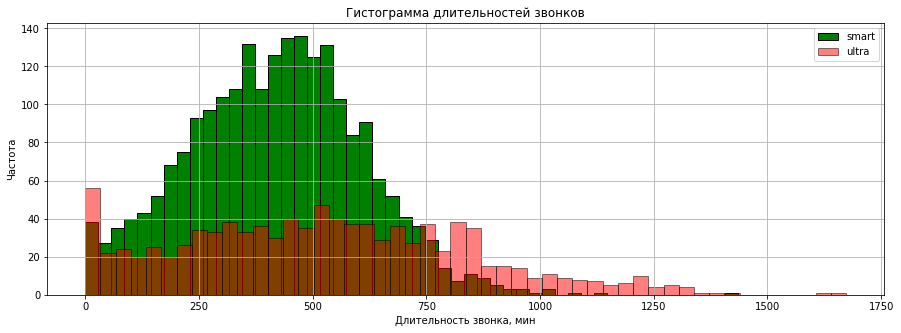

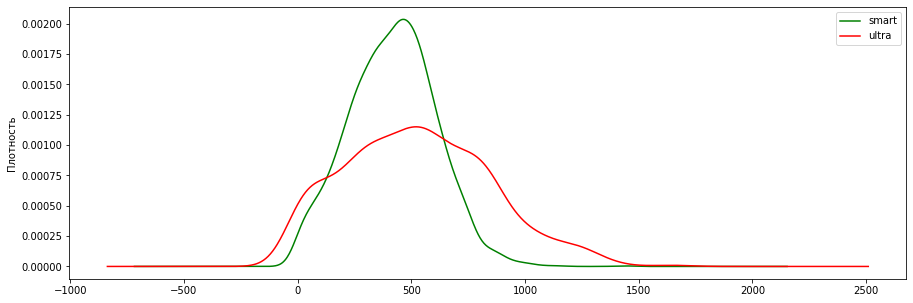

In [41]:
draw_hist(smart, ultra, 'duration_total', 'smart', 'ultra')
plt.title('Гистограмма длительностей звонков')
plt.xlabel('Длительность звонка, мин')
plt.ylabel('Частота')
draw_kde(smart, ultra, 'duration_total', 'smart', 'ultra')
plt.show()

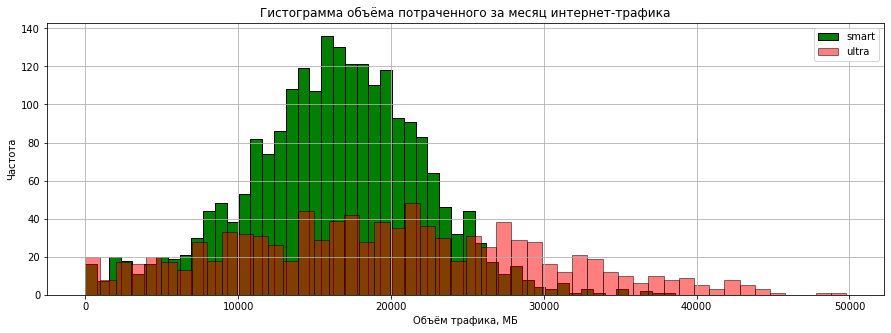

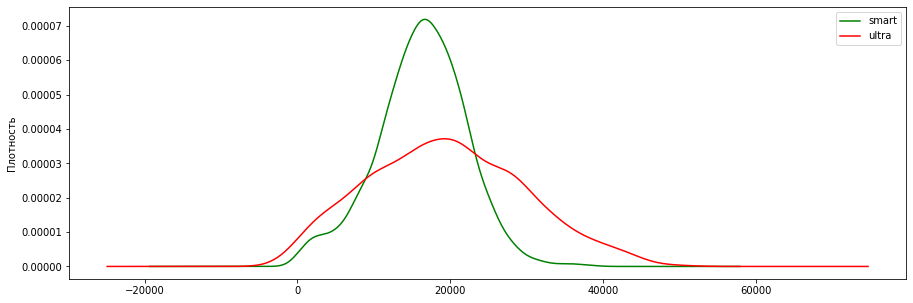

In [42]:
draw_hist(smart, ultra, 'mb_used_total', 'smart', 'ultra')
plt.title('Гистограмма объёма потраченного за месяц интернет-трафика')
plt.xlabel('Объём трафика, МБ')
plt.ylabel('Частота')
draw_kde(smart, ultra, 'mb_used_total', 'smart', 'ultra')
plt.show()

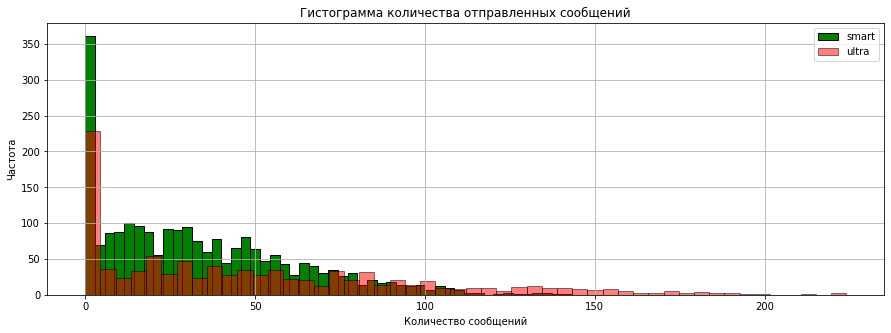

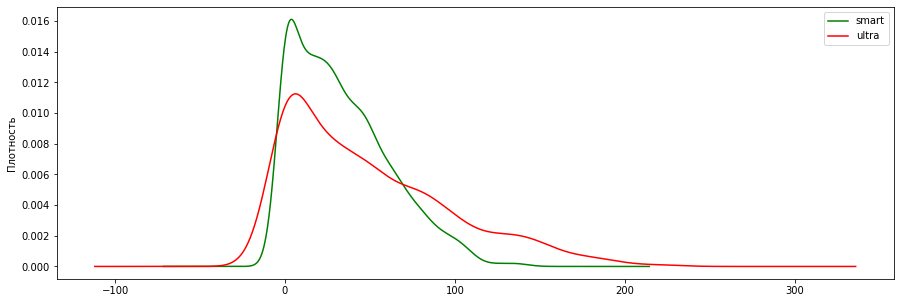

In [43]:
draw_hist(smart, ultra, 'messages_total', 'smart', 'ultra')
plt.title('Гистограмма количества отправленных сообщений')
plt.xlabel('Количество сообщений')
plt.ylabel('Частота')
draw_kde(smart, ultra, 'messages_total', 'smart', 'ultra')
plt.show()

### Вывод

Среднее, дисперсия и стандартное отклонение параметров «длительность звонков», «объём потраченного за сессию интернет-трафика» и «количество отправленных сообщений» у пользователей тарифа «Ультра» выше, чем у пользователей тарифа «Смарт». Это логично, ведь тариф «Ультра» дороже практически в 4 раза и покупается пользователями, которым нужно действительно много минут/трафика/сообщений ежемесячно, а возможный разброс включённых в тариф ресурсов больше в 6, 2 и 20 раз соответственно.

Распределения длительностей звонков и объёма потраченного за сессию интернет-трафика нормальные вне зависимости от тарифа. Количество отправленных сообщений имеет скошенное вправо нормальное распределение, причём пики в нулях на графиках распределений звонков и сообщений говорят о том, что время звонков и SMS прошло и пользователи всё чаще предпочитают звонить и отправить сообщения через мессенджеры.

## <a id='hypothesis_testing'>Шаг 4. Проверка гипотез</a>

In [44]:
def hypothesis_testing(df1, df2, column, equal_var=True, alpha=.05):
    results = st.ttest_ind(
        df1[column],
        df2[column],
        equal_var = equal_var)

    print('p-значение:', results.pvalue.round(5))

    if results.pvalue < alpha:
        print('Отвергаем нулевую гипотезу.')
    else:
        print('Не получилось отвергнуть нулевую гипотезу.')

**Нулевая гипотеза $H_0$**:
Средняя выручка с пользователей тарифов «Ультра» и «Смарт» одинакова.

**Альтернативная гипотеза $H_1$**:
Средняя выручка с пользователей тарифов «Ультра» и «Смарт» различается.

In [45]:
int(np.var(smart['proceeds_total'], ddof=1))

673931

In [46]:
int(np.var(ultra['proceeds_total'], ddof=1))

143491

In [47]:
hypothesis_testing(smart, ultra, 'proceeds_total', equal_var=False) # дисперсии отличаются примерно в 4.5 раза
print('Средняя выручка с пользователя тарифа «Смарт»:', int(smart['proceeds_total'].mean()))
print('Средняя выручка с пользователя тарифа «Ультра»:', int(ultra['proceeds_total'].mean()))

p-значение: 0.0
Отвергаем нулевую гипотезу.
Средняя выручка с пользователя тарифа «Смарт»: 1294
Средняя выручка с пользователя тарифа «Ультра»: 2071


***

**Нулевая гипотеза $H_0$**:
Средняя выручка с пользователей из Москвы равна выручке с пользователей из других регионов.

**Альтернативная гипотеза $H_1$**:
Средняя выручка с пользователей из Москвы отличается от выручки с пользователей из других регионов.

In [48]:
moscow = entire_info.query('city == "Москва"')
other = entire_info.query('city != "Москва"')

In [49]:
int(np.var(moscow['proceeds_total'], ddof=1))

566183

In [50]:
int(np.var(other['proceeds_total'], ddof=1))

656766

In [51]:
hypothesis_testing(moscow, other, 'proceeds_total')
print('Средняя выручка с пользователя из Москвы:', int(moscow['proceeds_total'].mean()))
print('Средняя выручка с пользователя из регионов:', int(other['proceeds_total'].mean()))

p-значение: 0.53167
Не получилось отвергнуть нулевую гипотезу.
Средняя выручка с пользователя из Москвы: 1550
Средняя выручка с пользователя из регионов: 1528


### <a id='best_tariff'>Какой тариф лучше?</a>

#### Посчитаем количество пользователей каждого тарифа в выборке.

In [52]:
users.query('tariff == "smart"').shape[0]

351

In [53]:
users.query('tariff == "ultra"').shape[0]

149

#### Посчитаем среднюю выручку за рассматриваемый период с пользователей каждого тарифа в целом по выборке.

In [54]:
int(users.query('tariff == "smart"').shape[0] * smart['proceeds_total'].mean())

454418

In [55]:
int(users.query('tariff == "ultra"').shape[0] * ultra['proceeds_total'].mean())

308588

### Вывод

Сформулировано две гипотезы:
1. Средняя выручка с пользователей тарифов «Ультра» и «Смарт» одинакова.
2. Средняя выручка с пользователей из Москвы равна выручке с пользователей из других регионов.

Проверка гипотез выполнялась в помощью t-теста Стьюдента для среднего двух независимых выборок. При проверке гипотез был выбран стандартный уровень значимости в 5%.

Первая гипотеза была отвергнута со стремящимся к нулю p-значением. Отвергнуть вторую гипотезу не удалось с p-значением в 0.5.

То, что средняя выручка с пользователя тарифа «Ультра» больше практически в 2 раза, выглядит логично, так как данный тарифный план дороже практически в 4 раза и им пользуются люди, готовые платить такие деньги.

Средняя выручка с пользователей тарифа «Смарт» за рассматриваемый период в целом по выборке больше в 1.5 раза, однако и число пользователей этого тарифа в выборке больше в 2 с лишним раза. Если соотношение пользователей тарифных планов такое же и в генеральной совокупности, то тариф «Смарт» лучше, так как приносит «Мегалайну» большую прибыль.

## <a id='general_conclusion'>Шаг 5. Общий вывод</a>

На вход поступило 5 датафреймов:

1. Датафрейм **calls** состоит из 202607 строк и 4 столбцов. Пропусков нет. Тип данных в столбце *call_date* — *object*, а не *datetime*. Значения в столбце *duration* представлены числами с плавающей запятой, хотя «Мегалайн» всегда округляет вверх значения минут. Имеются звонки длительностью 0 минут 0 секунд.
2. Датафрейм **internet** состоит из 149396 строк и 5 столбцов. Столбец *Unnamed: 0* является фиктивным и совпадает с индексами строк. Пропусков нет. Тип данных в столбце *session_date* — *object*, а не *datetime*. Значения в столбце *mb_used* представлены числами с плавающей запятой, хотя «Мегалайн» всегда округляет вверх значения мегабайтов.
3. Датафрейм **messages** состоит из 123036 строк и 3 столбцов. Пропусков нет. Тип данных в столбце *message_date* — *object*, а не *datetime*.
4. Датафрейм **tariffs** состоит из 2 строк и 8 столбцов. Пропусков нет.
5. Датафрейм **users** состоит из 500 строк и 8 столбцов. 462 из 500 значений в столбце *churn_date* пропущены. Типы данных в столбцах *churn_date* и *reg_date* — *object*, а не *datetime*.

Все даты были приведены к формату *datetime*.

Данные о минутах разговора и потраченных мегабайтах были округлены вверх и приведены к целочисленному типу.

Посчитана доля звонков продолжительностью 0 минут. Оказалось, что практически каждый пятый звонок имеет такую продолжительность. Возможно, это пропущенные звонки самим абонентом или звонки, поступившие собеседнику абонента, пропустившему звонок. В таком случае не обрабатывать их вполне логично. Если звонок продолжительностью менее минуты состоялся, то соответствующее значение округлено до 1 минуты. Если же звонок не состоялся, то абонент не потратил минуту по тарифу или сверх тарифа.

Фиктивный столбец *Unnamed: 0* датафрейма **internet** был удалён.

Пропущенные значения в столбце *churn_date* датафрейма **users**, скорее всего, означают, что пользователь до сих пор пользуется тарифным планом.

Для каждого пользователя были посчитаны:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объём израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя.

Среднее, дисперсия и стандартное отклонение параметров «длительность звонков», «объём потраченного за сессию интернет-трафика» и «количество отправленных сообщений» у пользователей тарифа «Ультра» выше, чем у пользователей тарифа «Смарт». Это логично, ведь тариф «Ультра» дороже практически в 4 раза и покупается пользователями, которым нужно действительно много минут/трафика/сообщений ежемесячно, а возможный разброс включённых в тариф ресурсов больше в 6, 2 и 20 раз соответственно.

Распределения длительностей звонков и объёма потраченного за сессию интернет-трафика нормальные вне зависимости от тарифа. Количество отправленных сообщений имеет скошенное вправо нормальное распределение, причём пики в нулях на графиках распределений звонков и сообщений говорят о том, что время звонков и SMS прошло и пользователи всё чаще предпочитают звонить и отправить сообщения через мессенджеры.

Сформулировано две гипотезы:
1. Средняя выручка с пользователей тарифов «Ультра» и «Смарт» одинакова.
2. Средняя выручка с пользователей из Москвы равна выручке с пользователей из других регионов.

Проверка гипотез выполнялась в помощью t-теста Стьюдента для среднего двух независимых выборок. При проверке гипотез был выбран стандартный уровень значимости в 5%. 

Первая гипотеза была отвергнута со стремящимся к нулю p-значением. Отвергнуть вторую гипотезу не удалось с p-значением в 0.5.

## Какой тариф лучше?

То, что средняя выручка с пользователя тарифа «Ультра» больше практически в 2 раза, выглядит логично, так как данный тарифный план дороже практически в 4 раза и им пользуются люди, готовые платить такие деньги.

Средняя выручка с пользователей тарифа «Смарт» за рассматриваемый период в целом по выборке больше в 1.5 раза, однако и число пользователей этого тарифа в выборке больше в 2 с лишним раза. Если соотношение пользователей тарифных планов такое же и в генеральной совокупности, то тариф «Смарт» лучше, так как приносит «Мегалайну» большую прибыль.